In [1]:
import arviz as az
import io
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from pathlib import Path
import pymc as pm
import pytensor.tensor as pt
import requests
import statsmodels.api as sm
import warnings
import xarray as xr

#seed = sum(map(ord, "PyMC LABS - BVAR"))
#rng = np.random.default_rng(seed=seed)

warnings.filterwarnings(
    "ignore",
    category=UserWarning,
    module="openpyxl.worksheet._reader",
)

In [2]:
def companion_eigs(A_draw):
    """
    A_draw: (p, K, K) with VAR form y_t = sum_{l=1}^p A_l y_{t-l} + ...
    Returns eigenvalues of the companion matrix.
    """
    p, K, _ = A_draw.shape
    C = np.zeros((K*p, K*p))
    C[:K, :K*p] = np.hstack([A_draw[l] for l in range(p)])
    if p > 1:
        C[K:, :-K] = np.eye(K*(p-1))
    return np.linalg.eigvals(C)

def irf_from_A(A_draw, shock_idx, horizons=40, shock_size=1.0):
    """
    A_draw: (p, K, K)
    shock_idx: index of shocked variable in vars_endog ordering
    horizons: number of steps ahead
    shock_size: size of shock applied to y_t at impact (in the same units as the standardized data)
    Returns: (horizons+1, K) IRF path.
    """
    p, K, _ = A_draw.shape

    # Companion matrix
    C = np.zeros((K*p, K*p))
    C[:K, :K*p] = np.hstack([A_draw[l] for l in range(p)])
    if p > 1:
        C[K:, :-K] = np.eye(K*(p-1))

    # Impact shock to current period
    state = np.zeros(K*p)
    state[shock_idx] = shock_size

    out = np.zeros((horizons+1, K))
    out[0] = state[:K]

    for h in range(1, horizons+1):
        state = C @ state
        out[h] = state[:K]

    return out

def companion_eigs(A_draw):
    """
    A_draw: (lags, K, K) with VAR form y_t = sum_{l=1}^p A_l y_{t-l} + ...
    returns eigenvalues of companion matrix
    """
    p, K, _ = A_draw.shape
    C = np.zeros((K*p, K*p))
    C[:K, :K*p] = np.hstack([A_draw[l] for l in range(p)])
    if p > 1:
        C[K:, :-K] = np.eye(K*(p-1))
    return np.linalg.eigvals(C)

In [3]:
data_path = Path(Path.cwd().parent / "data processed" / "nato_dataset.csv")
print("NATO dataset")
print("Full file path: ",data_path)
print("File exists: ",data_path.exists())

NATO dataset
Full file path:  /Users/awalters/escp_phd/govt_spending/data processed/nato_dataset.csv
File exists:  True


In [4]:
df = pd.read_csv(data_path)
df = df.copy()
df = df.set_index("year")

In [5]:
countries_iso = ['BEL', 'CHE', 'DNK', 'ESP', 'FIN', 'FRA', 'GBR', 'ITA', 'NLD', 'NOR', 'PRT', 'SWE']
countries_names = ['Belgium', 'Switzerland', 'Denmark', 'Spain', 'Finland', 'France', 'United Kingdom', 'Italy', 'Netherlands', 'Norway', 'Portugal', 'Sweden']

In [6]:
country_iso = "BEL"
country_name = "Belgium"

In [7]:
df = df.loc[df["iso"] == country_iso]

In [8]:
df

,iso,mil_delta,log_rgdp_pc,log_gov_pc,log_tfp,tbill,def_gdp,debt_gdp
year,,,,,,,,
1953,BEL,0.017696,1.949283,0.487863,1.440028,1.4000,-4.360491,68.6405
1954,BEL,-1.096842,1.971972,0.490545,1.477510,1.4000,-4.873439,69.6069
1955,BEL,-0.225249,2.031935,0.476961,1.505632,1.4000,-2.927289,68.2519
1956,BEL,0.050236,2.059166,0.477863,1.534980,1.4000,-1.997915,65.2228
1957,BEL,-0.037443,2.078468,0.532640,1.548565,1.6200,-2.384903,62.6271
...,...,...,...,...,...,...,...,...
2015,BEL,-0.013745,3.375744,2.088248,2.554754,-0.2200,-1.279020,105.2000
2016,BEL,-0.011248,3.383247,2.090406,2.553531,-0.2637,-2.553146,105.0000
2017,BEL,0.005605,3.391830,2.072239,2.550922,-0.3291,-1.261678,102.0000


In [9]:
vars_endog = [
    "mil_delta", #defense spending as % of gdp, change over next year
    "log_gov_pc",
    "log_rgdp_pc",
    "tbill",
    "log_tfp",
    "def_gdp",
    "debt_gdp",
    ]

data = df[vars_endog].dropna().copy()

# strongly recommended for 60 lags
data_z = (data - data.mean()) / data.std()

Y = data_z.values
T, K = Y.shape

lags = 15

# Target: y_t for t = lags..T-1
Y_target = Y[lags:]                      # shape (T-lags, K)

# Lagged predictors: stack y_{t-1},...,y_{t-lags}
# shape (T-lags, lags, K)
Xlags = np.stack([Y[lags-(i+1):-(i+1)] for i in range(lags)], axis=1)

print("Y_target:", Y_target.shape, "Xlags:", Xlags.shape, "K:", K, "T:", T)

Y_target: (52, 7) Xlags: (52, 15, 7) K: 7 T: 67


In [10]:
K = len(vars_endog)

coords = {
    "time": np.arange(Y_target.shape[0]),
    "vars": vars_endog,
    "cross_vars": vars_endog,
    "lags": np.arange(1, lags+1),
}

# --- Minnesota hyperparameters ---
lambda_ = 0.12   # overall tightness
alpha   = 1.5    # lag decay
theta   = 0.25   # cross-variable shrinkage (<1)

lag_idx = np.arange(1, lags+1)
lag_scale = lambda_ / (lag_idx ** alpha)            # (lags,)

own_mask = np.eye(K)
cross_mask = 1 - own_mask
var_scale = own_mask + theta * cross_mask           # (K,K)

# prior std for each coefficient: sigma[l, eq, var]
sigma_A = lag_scale[:, None, None] * var_scale[None, :, :]  # (lags,K,K)

# Optional: random-walk mean (own lag-1 centered at 1, others at 0)
mu_A = np.zeros((lags, K, K))
rw_vars = {"log_rgdp_pc", "log_rgov", "log_tfp"}          # these are in logs in your VAR
# everything else (tbill, totdefgdp, feddebtgdp, pdvmily) gets mean 0 on own lag 1

for j, name in enumerate(vars_endog):
    if name in rw_vars:
        mu_A[0, j, j] = 1.0

with pm.Model(coords=coords) as BVAR_model:
    X = pm.Data("Xlags", Xlags, dims=("time","lags","cross_vars"))
    Yobs = pm.Data("Y_target", Y_target, dims=("time","vars"))

    intercept = pm.Normal("intercept", 0.0, 1.0, dims=("vars",))
    noise = pm.HalfNormal("noise", 1.0, dims=("vars",))

    lag_coefs = pm.Normal(
        "lag_coefs",
        mu=pt.constant(mu_A.astype("float32")),
        sigma=pt.constant(sigma_A.astype("float32")),
        dims=("lags","vars","cross_vars")
    )

    mean = intercept + pt.einsum("tlk,ljk->tj", X, lag_coefs)

    obs = pm.Normal("obs", mu=mean, sigma=noise, observed=Yobs, dims=("time","vars"))

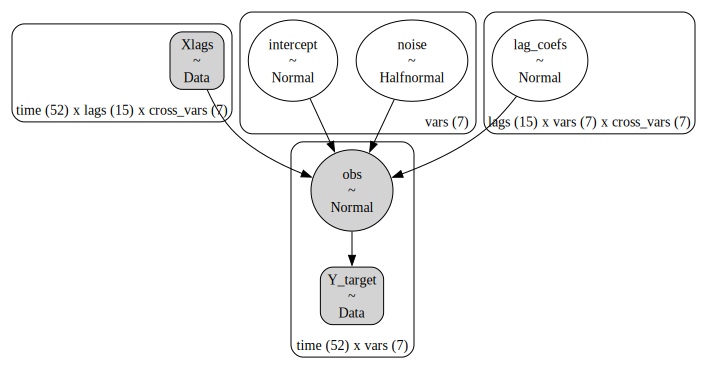

In [11]:
pm.model_to_graphviz(BVAR_model)

In [12]:
with BVAR_model:
    trace = pm.sample(
        draws=1000,
        tune=1000,
        chains=10,
        cores=10,
        target_accept=0.95,
    )

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (10 chains in 10 jobs)
NUTS: [intercept, noise, lag_coefs]


Output()

Sampling 10 chains for 1_000 tune and 1_000 draw iterations (10_000 + 10_000 draws total) took 26 seconds.


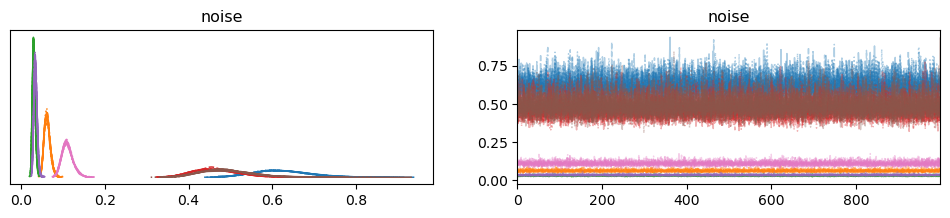

In [13]:
az.plot_trace(trace, var_names=["noise"]);

In [14]:
post = trace.posterior.stack(sample=("chain","draw"))
A = post["lag_coefs"].values   # (lags, vars, cross_vars, sample)
A = np.moveaxis(A, -1, 0)      # (sample, lags, K, K)

rng = np.random.default_rng(123)
idx = rng.choice(A.shape[0], size=min(200, A.shape[0]), replace=False)

max_mods = []
for i in idx:
    eigs = companion_eigs(A[i])
    max_mods.append(np.max(np.abs(eigs)))

np.mean(np.array(max_mods) < 1), np.quantile(max_mods, [0.5, 0.9, 0.99])

(np.float64(0.96), array([0.9446993 , 0.98686115, 1.01658012]))

In [15]:
# --- 1) Shock setup (already agreed) ---
shock_var = "mil_delta"
shock_idx = vars_endog.index(shock_var)

typical_scale = np.nanmedian(np.abs(data[shock_var].values))
shock_unstd = 1.0
shock_std = shock_unstd / data[shock_var].std()

# --- 2) (Optional but recommended) filter stable draws ---
post = trace.posterior.stack(sample=("chain","draw"))
A = post["lag_coefs"].values          # (lags, K, K, sample)
A = np.moveaxis(A, -1, 0)             # (sample, lags, K, K)

max_mods = np.array([np.max(np.abs(companion_eigs(A[i]))) for i in range(A.shape[0])])
stable_idx = np.where(max_mods < 1)[0]     # comment this line out if you don't want filtering

# choose which draws to use
rng = np.random.default_rng(123)
use_pool = stable_idx if stable_idx.size > 0 else np.arange(A.shape[0])
use = rng.choice(use_pool, size=min(10000, use_pool.size), replace=False)

# --- 3) Compute IRFs in standardized units ---
H = 15
irfs_std = np.stack(
    [irf_from_A(A[i], shock_idx, horizons=H, shock_size=shock_std) for i in use],
    axis=0
)  # (draw, H+1, K)

# --- 4) Undo standardization so outputs are in original units of each series ---
stds = data[vars_endog].std().to_numpy()          # (K,)
irfs = irfs_std * stds[None, None, :]             # (draw, H+1, K)

# --- 5) Sanity check: shocked var impact should equal shock_unstd (≈1.0 pp) ---
print("Median impact response (def_delta):", np.median(irfs[:, 0, shock_idx]),
      "| target:", shock_unstd)

# --- 6) Optional: convert log variables to percent (approx) for plotting ---
log_vars = {"log_rgov_pc", "log_rgdp_pc", "log_tfp"}  # adjust to your actual names
irfs_plot = irfs.copy()
for j, name in enumerate(vars_endog):
    if name in log_vars:
        irfs_plot[:, :, j] = 100.0 * irfs[:, :, j]  # log-points ≈ percent for small moves

Median impact response (def_delta): 1.0 | target: 1.0


In [16]:
print(data.describe().T[["mean","std","min","max"]])

                  mean        std        min         max
mil_delta    -0.057562   0.165571  -1.096842    0.303618
log_gov_pc    1.659007   0.559185   0.476961    2.183352
log_rgdp_pc   2.882609   0.452678   1.949283    3.415407
tbill         4.803266   3.880147  -0.356300   15.250000
log_tfp       2.173401   0.361296   1.440028    2.558261
def_gdp      -4.495205   3.169853 -14.285372   -0.113086
debt_gdp     87.647232  29.703422  38.843010  135.200000


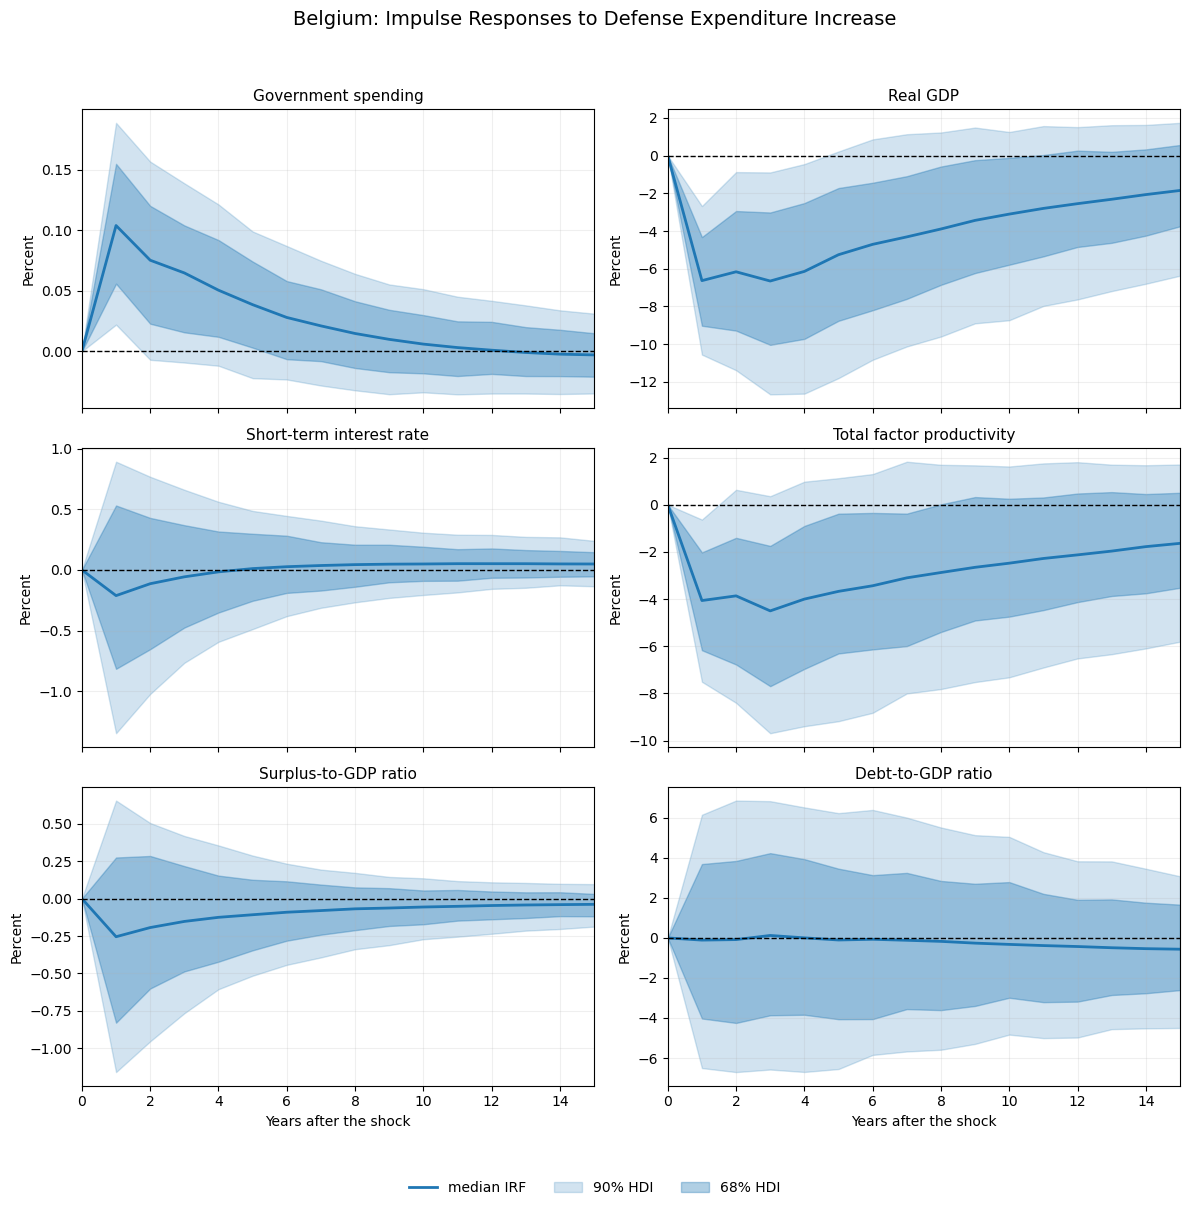

In [17]:
horiz_years = np.arange(H + 1)

# --- layout ---
nrows, ncols = 3, 2
fig, axes = plt.subplots(nrows, ncols, figsize=(12, 12), sharex=True)
axes = axes.ravel()

xmax = 15
xticks = np.arange(0, xmax + 1, 2)

pretty = {
    "log_gov_pc": "Government spending",
    "log_rgdp_pc": "Real GDP",
    "tbill": "Short-term interest rate",
    "log_tfp": "Total factor productivity",
    "def_gdp": "Surplus-to-GDP ratio",
    "debt_gdp": "Debt-to-GDP ratio",
}

names = vars_endog[1:]  # skip shock var
for ax, name in zip(axes, names):
    j = vars_endog.index(name)  # robust index into irfs_plot

    y = irfs_plot[:, :, j]                 # (draw, horizon)
    med = np.median(y, axis=0)

    arr = xr.DataArray(y, dims=("draw", "horizon")).expand_dims(chain=[0])
    hdi68 = az.hdi(arr, hdi_prob=0.68).to_array().squeeze()
    hdi90 = az.hdi(arr, hdi_prob=0.90).to_array().squeeze()

    lo68 = hdi68.sel(hdi="lower").values
    hi68 = hdi68.sel(hdi="higher").values
    lo90 = hdi90.sel(hdi="lower").values
    hi90 = hdi90.sel(hdi="higher").values

    ax.plot(horiz_years, med, linewidth=2, color="C0", label="median IRF")
    ax.fill_between(horiz_years, lo90, hi90, alpha=0.20, color="C0", label="90% HDI")
    ax.fill_between(horiz_years, lo68, hi68, alpha=0.35, color="C0", label="68% HDI")

    ax.axhline(0, lw=1, ls="--", color="black")  # dashed zero line
    ax.set_xlim(0, xmax)
    ax.set_xticks(xticks)

    ax.set_title(pretty.get(name, name), fontsize=11)
    ax.set_ylabel("Percent")
    ax.grid(alpha=0.2)

# turn off any unused axes (if < 6 plots)
for k in range(len(names), len(axes)):
    axes[k].axis("off")

# x-label only on bottom row
for ax in axes[-ncols:]:
    ax.set_xlabel("Years after the shock")

# one shared legend (avoid repeating)
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc="lower center", ncol=3, frameon=False)

fig.suptitle(country_name+": Impulse Responses to Defense Expenditure Increase", y=0.995, fontsize=14)
fig.tight_layout(rect=[0, 0.05, 1, 0.97])
plt.savefig(Path.cwd().parent / "figures" / f"{country_iso}.png")